In [46]:
import os
from astropy.io import ascii
import math
from astropy.coordinates import Angle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
%matplotlib inline
from astropy.modeling import models, fitting


In [2]:
ObjectFile = 'n2419c.selected'
CenterLine = 'n2419c             7:38:09.20   38:51:12.0  2000.0 PA=50.000 ##'
ha0 = 0
PA0 = 50
blue = 4000
red = 9000
sep_slit = 2
min_slit = 10
slit_width = 1
equinox = 2000

## List any necessary constants here

In [33]:
CODE_AS = -2
CODE_GS = -1
PRIMARY = 1
FLDCEN_X = 0
FLDCEN_Y = 270
FLIP = -1
YMSKMIN = 187.3
YMSKMAX = 479.1
XUPP_LIM = 498
XLOW_LIM = -498
YCAMCEN = 700
RADVIGN = 302
GAP1CEN =        -254.4          # CCD gap in arcsec -- center
GAP1HWD =           5.2          # CCD gap in arcsec -- half-wid
GAP2CEN =           0.0          # CCD gap in arcsec -- center
GAP2HWD =           5.2          # CCD gap in arcsec -- half-wid
GAP3CEN =         254.4          # CCD gap in arcsec -- center
GAP3HWD =           5.2          # CCD gap in arcsec -- half-wid
M_RCURV = 2120.9
R_IMSURF = 2133.6
M_ANGLE = 6.0
ZPT_YM = 128.803 # Dist to tel.axis, in SMCS-XXX (mm) 5.071in
MASK_HT0 = 3.378
PPLDIST  = 20018.4
FL_TEL  =150327.0


In [4]:
def degtorad(angle):
    return float(angle*np.pi/180)
def radtodeg(radians):
    return float(radians*57.295779513082320877)
def hhmmsstodegrees(hours):
    return Angle(str(hours)+' hours').degree
def ddmmsstodegrees(dms):
    return Angle(str(dms)+ ' degrees').degree

In [5]:
def InputDataInit():
    InputData={}
    InputData['DEF_BOXR']=0.5*4 # arcseconds for alignment boxes
    InputData['DEF_SLWID']=1 # default slit width arcseconds
    InputData['DEF_HLEN']=5 # minimum slit length
    InputData['RA0_FLD']=degtorad(hhmmsstodegrees(CenterLine.split()[1]))
    InputData['DEC0_FLD']=degtorad(ddmmsstodegrees(CenterLine.split()[2]))
    InputData['HA_FLD']=degtorad(ha0*15)
    InputData['PA_ROT']=degtorad(PA0)
    InputData['TEMP']=0
    InputData['PRES']=600
    InputData['WAVER']=7000*1e-4
    InputData['WAVEMN']=blue*1e-4
    InputData['WAVEMX']=red*1e-4
    InputData['SLIT_GAP'] = sep_slit
    InputData['DEF_HLEN'] = 0.5 * min_slit
    InputData['DEF_SLWID'] = slit_width
    InputData['STD_EQX'] = equinox
    InputData['RA_FLD']=InputData['RA0_FLD'] # no refraction
    InputData['DEC_FLD']=InputData['DEC0_FLD']
    InputData['PROJ_LEN']=True
    return InputData
    

In [6]:
def TargetInit():
    TargetData=[]
 
    data = ascii.read(ObjectFile, format='no_header', names=['id','ra','dec','equinox','mag','band','priority','nlist','selcode','pangle'])
    for i in range(len(data)):
        Target={}
        Target['INDEX']=i
        Target['IDSTR']=data['id'][i]
        ra0=degtorad(hhmmsstodegrees(data['ra'][i]))
        Target['RA0']=ra0
        dec0=degtorad(ddmmsstodegrees(data['dec'][i]))
        Target['DEC0']=dec0
        Target['RA']=Target['RA0'] # no refraction
        Target['DEC']=Target['DEC0']
        Target['MAG']=data['mag'][i]
        Target['PBAND']=data['band'][i][0]
        l1=InputData['DEF_HLEN']
        l2=InputData['DEF_HLEN']
        selcode=0
        nlist=PRIMARY
        Target['PCODE']=data['priority'][i]
        Target['STD_EQX']=data['equinox'][i]
        if data['priority'][i]==CODE_AS:
                l1 = InputData['DEF_BOXR']
                l2 = InputData['DEF_BOXR']
        Target['PA']=data['pangle'][i]
 
        if Target['PCODE']==CODE_AS:
                print("Star %s is an alignment star" % Target['IDSTR'])
                Target['PA']=''
                Target['SLWID']=2*InputData['DEF_BOXR']
        else:
                Target['SLWID']=InputData['DEF_SLWID']
        Target['SAMPL']=nlist
        Target['SEL']=data['selcode'][i]
        
        Target['LEN1']=l1
        Target['LEN2']=l2
        TargetData.append(Target)
        
    return(TargetData)

In [7]:
# read input data
InputData = InputDataInit()
# read targets
TargetData = TargetInit()
print(TargetData[0])

Star N2419-D17 is an alignment star
Star N2419-S130 is an alignment star
Star N2419-S147 is an alignment star
Star N2419-S1601 is an alignment star
Star N2419-S1778 is an alignment star
Star N2419-S345 is an alignment star
{'INDEX': 0, 'IDSTR': 'N2419-D17', 'RA0': 2.0002502972113687, 'DEC0': 0.6796521546776157, 'RA': 2.0002502972113687, 'DEC': 0.6796521546776157, 'MAG': 17.52, 'PBAND': 'I', 'PCODE': -2, 'STD_EQX': 2000, 'PA': '', 'SLWID': 4.0, 'SAMPL': 1, 'SEL': 1, 'LEN1': 2.0, 'LEN2': 2.0}


## Calculate position with reference to telescope axis

In [8]:
def fld2telax(InputData):
    r = degtorad(np.sqrt(FLDCEN_X*FLDCEN_X+FLDCEN_Y*FLDCEN_Y)/3600)
    pa_fld = np.arctan2(FLDCEN_Y,FLDCEN_X)
    cosr = np.cos(r)
    sinr = np.sin(r)
    cosd = np.cos(InputData['DEC_FLD'])
    sind = np.sin(InputData['DEC_FLD'])
    cost = np.cos(InputData['PA_ROT']-pa_fld)
    sint = np.sin(InputData['PA_ROT']-pa_fld)
    sina = sinr*sint/cosd
    cosa = np.sqrt(1-sina**2)
    InputData['RA_TEL']=InputData['RA_FLD']
    InputData['DEC_TEL']=np.arcsin((sind*cosd*cosa-cosr*sinr*cost)/(cosr*cosd*cosa-sinr*sind*cost))
    return InputData

In [9]:
InputData = fld2telax(InputData)
InputData

{'DEC0_FLD': 0.6781185920415301,
 'DEC_FLD': 0.6781185920415301,
 'DEC_TEL': 0.67711612712619529,
 'DEF_BOXR': 2.0,
 'DEF_HLEN': 5.0,
 'DEF_SLWID': 1,
 'HA_FLD': 0.0,
 'PA_ROT': 0.8726646259971648,
 'PRES': 600,
 'PROJ_LEN': True,
 'RA0_FLD': 1.999071036413438,
 'RA_FLD': 1.999071036413438,
 'RA_TEL': 1.999071036413438,
 'SLIT_GAP': 2,
 'STD_EQX': 2000,
 'TEMP': 0,
 'WAVEMN': 0.4,
 'WAVEMX': 0.9,
 'WAVER': 0.7000000000000001}

## Calculate position of targets with reference to telescope axis

In [10]:
def tel_coords(InputData, TargetData):
    ra0 = InputData['RA_TEL']
    dec0 = InputData['DEC_TEL']
    pa0 = InputData['PA_ROT']
    for i in range(len(TargetData)):
        target = TargetData[i]
        
        try:
            dec_obj = target['DEC']
        except:
            print("Target is missing some values")
            print(target)
            return
        del_ra = target['RA']-ra0
        cosr = np.sin(dec_obj) * np.sin(dec0) + np.cos(dec_obj) * np.cos(dec0) * np.cos(del_ra)
        r = np.arccos(cosr)
        
        sinp = np.cos(dec_obj) * np.sin(del_ra) / np.sqrt(1-cosr*cosr)
        cosp = np.sqrt(max((1. - sinp*sinp),0))
        if (dec_obj < dec0):
                cosp = cosp * -1
        p = np.arctan2(sinp, cosp)
        
        r = np.tan(r)*206264.8


        target['XARCS'] = r * np.cos(pa0-p)
        target['YARCS'] = r * np.sin(pa0-p)
        
        if target['PA'] == '':
                target['RELPA'] = ''
                rangle=0
        else:
            target['RELPA'] = target['PA']-pa0
            rangle = target['RELPA']
            
        xgeom = FLIP * np.cos(rangle)
        ygeom = np.sin(rangle)
        
        if InputData['PROJ_LEN'] is True:
            xgeom = xgeom / np.abs(np.cos(rangle))
            ygeom = ygeom / np.abs(np.cos(rangle))
            
        if xgeom > 0:
            target['X1'] = target['XARCS']-target['LEN1']* xgeom
            target['Y1'] = target['YARCS']-target['LEN1']* ygeom
            target['X2'] = target['XARCS']+target['LEN2']* xgeom
            target['Y2'] = target['YARCS']+target['LEN2']* ygeom
        else:
            target['X2'] = target['XARCS']-target['LEN1']* xgeom
            target['Y2'] = target['YARCS']-target['LEN1']* ygeom
            target['X1'] = target['XARCS']+target['LEN2']* xgeom
            target['Y1'] = target['YARCS']+target['LEN2']* ygeom
            
        x=target['XARCS']
        y=target['YARCS']
        target['STAT'] = chk_stat(x,y)
        TargetData[i]=target
    return TargetData
        
def chk_stat(x,y):
    r = np.sqrt(x**2+y**2)
    if r>600:
        return False
    if y<YMSKMIN:
        return False
    if y>YMSKMAX:
        return False
    if x>XUPP_LIM or x<XLOW_LIM:
        return False
    if x>-0.98273*y+833.0:
        return False
    if (x**2+(y-YCAMCEN)**2 < RADVIGN**2):
        return False
    if (np.abs(x-GAP1CEN))< GAP1HWD:
            return False
    if (np.abs(x-GAP2CEN))< GAP2HWD:
            return False
    if (np.abs(x-GAP3CEN))< GAP3HWD:
            return False
        
    return True
    
                
        

In [11]:
TargetData = tel_coords(InputData, TargetData)
TargetData[0]

{'DEC': 0.6796521546776157,
 'DEC0': 0.6796521546776157,
 'IDSTR': 'N2419-D17',
 'INDEX': 0,
 'LEN1': 2.0,
 'LEN2': 2.0,
 'MAG': 17.52,
 'PA': '',
 'PBAND': 'I',
 'PCODE': -2,
 'RA': 2.0002502972113687,
 'RA0': 2.0002502972113687,
 'RELPA': '',
 'SAMPL': 1,
 'SEL': 1,
 'SLWID': 4.0,
 'STAT': True,
 'STD_EQX': 2000,
 'X1': 479.2120477872989,
 'X2': 483.2120477872989,
 'XARCS': 481.2120477872989,
 'Y1': 279.15783555606924,
 'Y2': 279.15783555606924,
 'YARCS': 279.15783555606924}

In [12]:
x = [x['XARCS'] for x in TargetData]
y = [x['YARCS'] for x in TargetData]

(0, 400)

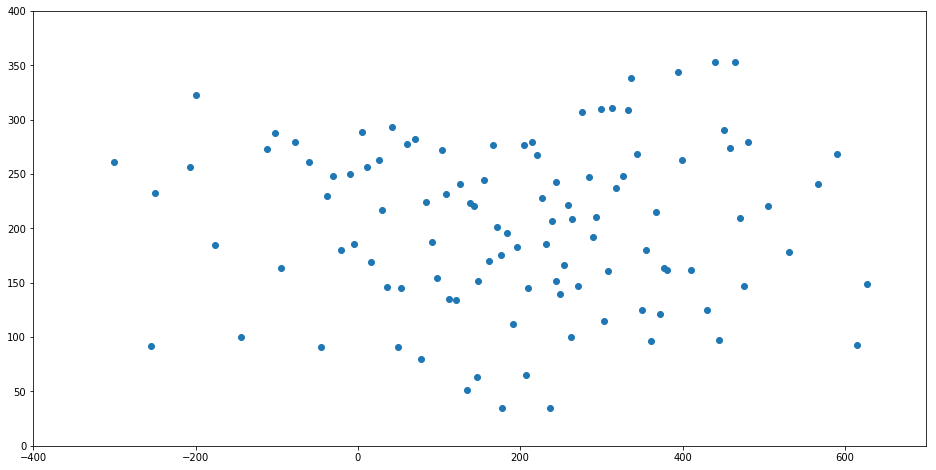

In [13]:
plt.figure(figsize=(16,8))
plt.plot(x,y,'o')
plt.xlim(-400,700)
plt.ylim(0,400)

In [14]:

def gs_restore(x_array, nval):
    gs_values()
    xorder = int(x_array[1])
    sf={}
    if xorder < 1:
        print("Error: Illegal x order")
        return
    yorder = int(x_array[2])
    if yorder < 1:
        print("Error: Illegal y order")
        return
    xmin = x_array[4]
    xmax = x_array[5]
    if (xmax<=xmin):
        print("Error: Illegal x range")
        return
    ymin = x_array[6]
    ymax = x_array[7]
    if (ymax<=ymin):
        print("Error: Illegal y range")
        return
    surface_type = int(x_array[0])
    if surface_type in [1,2,3]:
        sf['nxcoeff']=xorder
        sf['xorder']=xorder
        sf['xmin']=xmin
        sf['xmax']=xmax
        sf['xrange']=2.0/(xmax-xmin)
        sf['xmaxmin']=-(xmax+xmin)/2.0
        sf['nycoeff']=yorder
        sf['yorder']=yorder
        sf['ymin']=ymin
        sf['ymax']=ymax
        sf['yrange']=2.0/(ymax-ymin)
        sf['ymaxmin']=-(ymax+ymin)/2.0
        sf['xterms']=x_array[3]
        if sf['xterms']==0:
            sf['ncoeff']=sf['nxcoeff']+sf['nycoeff']-1
        if sf['xterms']==2:
            sf['ncoeff']=sf['nxcoeff']*sf['nycoeff']-order*(order-1)/2
        if sf['xterms']==1:
            sf['xcoeff']=sf['nxcoeff']*sf['nycoeff']
            
    sf['type']=surface_type
    sf['xbasis']=""
    sf['ybasis']=""
    sf['matrix']=""
    sf['chofac']=""
    sf['vector']=""
    sf['coeff']=""
    sf['wz']=""
    sf['coeff']=x_array[8:nval]
    return sf

            

In [15]:
def gs_add(sf1,sf2):
    sf3={}
    if sf1['type']!=sf2['type']:
        print("Error: surfaces are not the same type")
        return
    sf3['type']=sd1['type']
    if sf3['type'] in [1,2,3]:
        sf3['nxcoeff']=max(sf1['nxcoeff'],sf2['nxcoeff'])
        sf3['xorder']=max[sf1['xorder'],sf2['xorder']]
        sf3['xmin']=sf1['xmin']
        sf3['xmax']=sf1['xmax']
        sf3['xrange']=sf1['xrange']
        sf3['xmaxmin']=sf1['xmaxmin']
        sf3['nycoeff']=max(sf1['nycoeff'],sf2['nycoeff'])
        sf3['ymin']=sf1['ymin']
        sf3['ymax']=sf1['ymax']
        sf3['yrange']=sf1['yrange']
        sf3['ymaxmin']=sf1['ymaxmin']
        if sf1['xterms']==sf2['xterms']:
            sf3['xterms']=sf1['xterms']
        elif sf1['xterms']==1 or sf2['xterms']==1:
            sf3['xterms']=1
        else:
            sf3['xterms']=2
        if sf3['xterms']==0:
            sf3['ncoeff']=sf3['nxcoeff']+sf3['nycoeff']-1
        elif sf3['ncoeff']==2:
            order = min(sf3['xorder'],sf3['yorder'])
            sf3['ncoeff']=sf3['nxcoeff']*sf3['nycoeff']-order*(order-1)/2
        else:
            sf3['ncoeff']=sf3['nxcoeff']*sf3['nycoeff']
    sf3['xbasis']=""
    sf3['ybasis']=""
    sf3['matrix']=""
    sf3['chofac']=""
    sf3['vector']=""
    sf3['coeff']=""
    sf3['wz']=""
    
    maxorder1=max(sf1['xorder']+1,sf1['yorder']+1)
    maxorder2=max(sf2['xorder']+1,sf2['yorder']+1)
    maxorder3=max(sf3['xorder']+1,sf3['yorder']+1)
    
    ptr1=sf1['coeff']
    ptr3=sf3['coeff']
    nmove1=sf1['nxcoeff']
    nmove3=sf3['nxcoeff']
    for i in range(1,sf1['nycoeff']):
        ptr3=ptr1
        if sf1['xterms']==0:
            nmove=1
        if sf1['xterms']==2:
            if ((i+sf1['xorder'])+1)>maxorder1:
                nmove1=nmove1-1
        if sf1['xterms']==1:
            pass
        if sf3['xterms']==0:
            nmove=1
        if sf3['xterms']==2:
            if ((i+sf3['xorder'])+1)>maxorder3:
                nmove3=nmove3-1
        if sf3['xterms']==1:
            pass
        


In [16]:
def gs_ingest(fd):
    fp=open(fd)
    while True:
        line = fp.readline()
        if not line:
            break
        print(line)
        args = line.split()
        print(args)
        if args[0] == 'surface1':
            xargs=[]
            yargs=[]
            nval = int(args[1])
            for i in range(int(nval)):
                line = fp.readline()
                args=line.split()
                xargs.append(float(args[0]))
                yargs.append(float(args[1]))
            gsx1 = gs_restore(xargs,nval)
            print(gsx1)
            gsy1 = gs_restore(yargs,nval)
            print(gsy1)
        line = fp.readline()
        args = line.split()
        if args[0] == 'surface2':
            xargs=[]
            yargs=[]
            nval = int(args[1])
            for i in range(int(nval)):
                line = fp.readline()
                args=line.split()
                xargs.append(float(args[0]))
                yargs.append(float(args[1]))
            gsx2 = gs_restore(xargs,nval)
            gsy2 = gs_restore(yargs,nval)
    fp.close()
    #gsx = gsadd(gsx1, gsx2)
    #gsy = gsadd(gsy1, gsy2)

In [17]:
#gs_ingest('xproj.map')

In [18]:
# calculate 2D polynomial
fd = open('input.dat')
lines = fd.readlines()
fd.close()
xin = []
yin = []
for line in lines:
    p = line.split()
    xin.append(float(p[0]))
    yin.append(float(p[1]))

fd = open('output.dat')
lines = fd.readlines()
fd.close()
xout = []
yout = []
for line in lines:
    p = line.split()
    xout.append(float(p[0]))
    yout.append(float(p[1]))

px_init = models.Polynomial2D(degree=4)
fit_px = fitting.LevMarLSQFitter()
px1 = fit_px(px_init,xin,yin,xout)
py_init = models.Polynomial2D(degree=3)
fit_py = fitting.LevMarLSQFitter()
py1 = fit_py(py_init,xin,yin,yout)


In [19]:
print(px1.parameters)
print(py1.parameters)


[  1.03767274e+00  -2.18808149e-03   7.37670550e-08  -2.01076027e-11
   2.74918216e-15  -3.89696055e-03   2.02511462e-07  -1.62138047e-12
   8.10897848e-15   3.13514189e-07   2.88432985e-08  -3.72487474e-15
  -2.85152369e-10   2.37128749e-13  -2.41487157e-13]
[ -1.03918214e+00   1.00220205e+00  -6.72056480e-08  -7.98200666e-12
   3.90475878e-03  -2.15396384e-07  -9.58987366e-13  -3.20708206e-07
  -2.89136300e-08   2.32104252e-10]


In [20]:
xout_fit = []
yout_fit = []

xout_fit = px1(xin,yin)
yout_fit = py1(xin,yin)
        
# compare
for i in range(10):
        print(xin[i],yin[i],xout[i],yout[i],xout_fit[i],yout_fit[i])


0.0 0.0 1.037673 -1.03918 1.0376727355 -1.03918213522
0.0 1.0 1.033776 -1.03528 1.03377597746 -1.03527759183
0.0 2.0 1.02988 -1.03137 1.02987962443 -1.03137347925
0.0 3.0 1.025984 -1.02747 1.02598367641 -1.02746979746
0.0 4.0 1.022088 -1.02357 1.02208813338 -1.02356654649
0.0 5.0 1.018193 -1.01966 1.01819299534 -1.01966372634
0.0 6.0 1.014298 -1.01576 1.01429826228 -1.015761337
0.0 7.0 1.010404 -1.01186 1.01040393418 -1.0118593785
0.0 8.0 1.00651 -1.00796 1.00651001104 -1.00795785082
0.0 9.0 1.002617 -1.00406 1.00261649286 -1.00405675399


In [21]:
#plt.figure(figsize=(6,6))
#plt.plot(xin,yin)

In [22]:
#plt.figure(figsize=(6,6))
#plt.plot(xout_fit,yout_fit)

In [23]:
#plt.figure(figsize=(6,6))
#plt.plot(xout_fit,yout_fit)

In [24]:
def len_slits(TargetData,SlitData,InputData):
    sdat=SlitData.copy()
    bufx=[]
    bufi=[]
    for i in range(len(SlitData)):
        bufx.append(sdat[i]['XARCS'])
        bufi.append(sdat[i]['INDEX'])
        
    s = sorted(zip(bufx,bufi))
    bufx,bufi = map(list, zip(*s))
    print(len(sdat))
    for i in range(len(sdat)-2):
        ndx1=bufi[i]
        ndx2=bufi[i+1]
        index = ndx1

        pc1=sdat[ndx1]['PCODE']
        pc2=sdat[ndx2]['PCODE']
        
        # if both are alignment boxes, move on...
        if pc1==-2 and pc2==-2:
            next
            
        xlow = sdat[ndx1]['X2']+InputData['SLIT_GAP']
        xupp = sdat[ndx2]['X1']-InputData['SLIT_GAP']
        xcen = 0.5*(xlow+xupp)
        
        yas = sdat[ndx1]['Y2']
        dxlow = px1(xcen,yas)
        yas = sdat[ndx2]['Y1']
        dxupp = px1(xcen,yas)
        dxavg = 0.5 * (dxupp+dxlow)
        dxlow=dxlow-dxavg
        dxupp=dxupp-dxavg
        #print("%6.3f %6.3f\n" % (dxlow,dxupp))
        if (pc1 == -2):
            del1=0
            del2=sdat[ndx2]['X1']-xlow-(dxupp-dxlow)
        elif (pc2 == -2):
            del1=xupp-sdat[ndx1]['X2']+(dxlow-dxupp)
            del2=0
        else:
            del1=xcen-0.5*InputData['SLIT_GAP']-sdat[ndx1]['X2']+dxlow
            del2=sdat[ndx2]['X1']-(xcen+0.5*InputData['SLIT_GAP'])-dxupp
        #print(del1,del2)
        oldx2 = sdat[ndx1]['X2']
        sdat[ndx1]['X2']=sdat[ndx1]['X2']+del1
        newx2 = sdat[ndx1]['X2']
        if ndx1==15 or ndx2==15:
            print(index,oldx2,newx2)
        if (del1 !=0 and sdat[ndx1]['RELPA'] != ""):
            tana = np.tan(sdat[ndx1]['RELPA'])
            sdat[ndx1]['Y2']=sdat[ndx1]['Y2']+del1*(-1)*tana
        sdat[ndx2]['X1']=sdat[ndx2]['X1']-del2
        if (del2 !=0 and sdat[ndx2]['RELPA'] != ""):
            tana = np.tan(sdat[ndx2]['RELPA'])
            sdat[ndx2]['Y1']=sdat[ndx2]['Y1']+del2*(-1)*tana
    print(len(sdat))
    return sdat
    
def gen_slits(TargetData,InputData):
    
    SlitData = []
    # calculate number of selected targets
    nslit = 0
    for i in range(len(TargetData)):
        if TargetData[0]['SEL']==1:
            nslit+=1
    # sets up the slits
    ndx=0
    for i in range(len(TargetData)):
        slit = {}
        target = TargetData[i]
        if target['PCODE'] == CODE_GS:
            next
        if target['SEL'] == 1:
            x = target['XARCS']
            y = target['YARCS']
            if chk_stat(x,y) == False:
                next
            slit['INDEX']=ndx
            if target['PA']=='':
                slit['PA']=InputData['PA_ROT']
            else:
                slit['PA']=target['PA']
            slit['RELPA'] = target['RELPA']
            slit['PCODE'] = target['PCODE']
            slit['X1'] = target['X1']
            slit['X2'] = target['X2']
            slit['Y1'] = target['Y1']
            slit['Y2'] = target['Y2']
            
            slit['XARCS'] = target['XARCS']
            slit['YARCS'] = target['YARCS']
            slit['SLWID'] = target['SLWID']
            target['SLNDX'] = ndx
            SlitData.append(slit)
            ndx=ndx+1
            TargetData[i]=target
    print("Old value: ",SlitData[15]['INDEX'],SlitData[15]['X2'])
    SlitDataNew= len_slits(TargetData,SlitData,InputData)
    print("New value: ",SlitDataNew[15]['INDEX'],SlitDataNew[15]['X2'])
    return SlitDataNew
        

In [25]:

SlitData=gen_slits(TargetData,InputData)


Old value:  15 236.76021379
107
6 232.379013029 228.544708118
15 236.76021379 233.024366707
107
New value:  15 233.024366707


In [26]:
def sky_coords(SlitData, InputData):
    indat = InputData
    sdat = SlitData
    ra0=indat['RA_TEL']
    dec0 = indat['DEC_TEL']
    pa0 = indat['PA_ROT']
    
    for i in range(len(sdat)):
        x=0.5*(sdat[i]['X1']+sdat[i]['X2'])
        y=0.5*(sdat[i]['Y1']+sdat[i]['Y2'])
        
        r = np.sqrt(x**2+y**2)
        r = np.arctan(r/206264.8)
        phi = pa0-np.arctan2(y,x)
        sind = np.sin(dec0)*np.cos(r)+np.cos(dec0)*np.sin(r)*np.cos(phi)
        sina = np.sin(r)*np.sin(phi)*np.sqrt(1-sind**2)
        sdat[i]['DEC']=np.arcsin(sind)
        sdat[i]['RA']=ra0+np.arcsin(sina)
        
        sdat[i]['XARCS'] = 0.5*(sdat[i]['X1']+sdat[i]['X2'])
        sdat[i]['YARCS'] = 0.5*(sdat[i]['Y1']+sdat[i]['Y2'])
        
        x = sdat[i]['X2']-sdat[i]['X1']
        y = sdat[i]['Y2']-sdat[i]['Y1']
        sdat[i]['LEN1']=0.5*np.sqrt(x**2+y**2)
        sdat[i]['LEN2']=sdat[i]['LEN1']
    return sdat

In [27]:
SlitData = sky_coords(SlitData,InputData)
SlitData[1]

{'DEC': 0.67986838325616761,
 'INDEX': 1,
 'LEN1': 3.862843274063092,
 'LEN2': 3.862843274063092,
 'PA': 60,
 'PCODE': 16,
 'RA': 1.9995627320812983,
 'RELPA': 59.127335374002833,
 'SLWID': 1,
 'X1': 462.75919152145093,
 'X2': 466.90953020061437,
 'XARCS': 464.83436086103268,
 'Y1': 347.81625211780084,
 'Y2': 354.33245664867138,
 'YARCS': 351.07435438323614}

In [28]:
SlitData = tel_coords(InputData,SlitData)

In [29]:
SlitData[1]

{'DEC': 0.67986838325616761,
 'INDEX': 1,
 'LEN1': 3.862843274063092,
 'LEN2': 3.862843274063092,
 'PA': 60,
 'PCODE': 16,
 'RA': 1.9995627320812983,
 'RELPA': 59.127335374002833,
 'SLWID': 1,
 'STAT': True,
 'X1': 421.47002433141199,
 'X2': 429.19571087953818,
 'XARCS': 425.33286760547509,
 'Y1': 381.75486678621922,
 'Y2': 386.63002076613492,
 'YARCS': 384.19244377617707}

In [39]:
def gnom_to_dproj(xg,yg):
    DIST_C0 = 0
    DIST_C2 = -1.111311e-8
    rho = np.sqrt(xg**2+yg**2)
    cosa=yg/rho
    sina=xg/rho
    rho = rho * (1.+DIST_C0+DIST_C2*rho**2)
    xd = rho*sina
    yd = rho*cosa
    return xd,yd
   
def proj_to_mask(xp,yp,ap):


    mu = np.arcsin(xp/M_RCURV)
    cosm = np.cos(mu)
    cost = np.cos(degtorad(M_ANGLE))
    tant = np.tan(degtorad(M_ANGLE))
    xx = M_RCURV * mu
    yy = (yp-ZPT_YM)/cost + M_RCURV*tant*(1-cosm)
    
    tanpa = np.tan(degtorad(ap))*cosm/cost+tant*xp/M_RCURV
    ac = radtodeg(np.arctan(tanpa))
    
    #spherical image surface height
    rho = np.sqrt(xp*xp+yp*yp)
    hs = R_IMSURF*(1-np.sqrt(1-(rho/R_IMSURF)**2))
    # mask surface height
    hm = MASK_HT0 + yy * np.sin(degtorad(M_ANGLE))+M_RCURV*(1-cosm)
    #correction
    yc = yy + (hs - hm) * yp / PPLDIST / cost
    xc = xx + (hs - hm) * xp / PPLDIST / cosm
    return xc,yc,ac


    

In [40]:
def mask_coords(SlitData):
    asec_rad = 206264.8
    
    # offset from telescope axis to slitmask origin, in slitmask coordinates
    yoff = ZPT_YM*(1-np.cos(degtorad(M_ANGLE)))
    yoff = 0 #### CHECK!
    xoff = 0
    for i in range(len(SlitData)):
        sdat = SlitData[i]
        if sdat['RELPA']!="":
            cosa = np.cos(sdat['RELPA'])
            sina = np.sin(sdat['RELPA'])
        else:
            cosa=1
            sina=1

        # recalculation, probably not needed
        sdat['X1']=sdat['XARCS']-sdat['LEN1']*cosa*(-1)
        sdat['Y1']=sdat['YARCS']-sdat['LEN1']*sina
        sdat['X2']=sdat['XARCS']+sdat['LEN1']*cosa*(-1)
        sdat['Y2']=sdat['YARCS']+sdat['LEN2']*sina
    
        # x1,y1 are now tan projections
        xfp = FL_TEL*sdat['X1']/asec_rad
        yfp = FL_TEL*(sdat['Y1']-0.5*sdat['SLWID'])/asec_rad
        pa = 0
        xfp,yfp = gnom_to_dproj(xfp,yfp)
        xsm,ysm,pa = proj_to_mask(xfp,yfp,pa)
        sdat['XMM1']=xsm+xoff
        sdat['YMM1']=ysm+yoff
    
        xfp = FL_TEL*sdat['X2']/asec_rad
        yfp = FL_TEL*(sdat['Y2']-0.5*sdat['SLWID'])/asec_rad
        pa = 0
        xfp,yfp = gnom_to_dproj(xfp,yfp)
        xsm,ysm,pa = proj_to_mask(xfp,yfp,pa)
        sdat['XMM2']=xsm+xoff
        sdat['YMM2']=ysm+yoff
    
        xfp = FL_TEL*sdat['X2']/asec_rad
        yfp = FL_TEL*(sdat['Y2']+0.5*sdat['SLWID'])/asec_rad
        pa = 0
        xfp,yfp = gnom_to_dproj(xfp,yfp)
        xsm,ysm,pa = proj_to_mask(xfp,yfp,pa)
        sdat['XMM3']=xsm+xoff
        sdat['YMM3']=ysm+yoff
 
        xfp = FL_TEL*sdat['X1']/asec_rad
        yfp = FL_TEL*(sdat['Y1']+0.5*sdat['SLWID'])/asec_rad
        pa = 0
        xfp,yfp = gnom_to_dproj(xfp,yfp)
        xsm,ysm,pa = proj_to_mask(xfp,yfp,pa)
        sdat['XMM4']=xsm+xoff
        sdat['YMM4']=ysm+yoff
    
        # here we should call metal check
        SlitData[i]=sdat
        
    return SlitData
    


In [41]:
SlitData=mask_coords(SlitData)

In [42]:
SlitData[1]

{'DEC': 0.67986838325616761,
 'INDEX': 1,
 'LEN1': 3.862843274063092,
 'LEN2': 3.862843274063092,
 'PA': 60,
 'PCODE': 16,
 'RA': 1.9995627320812983,
 'RELPA': 59.127335374002833,
 'SLWID': 1,
 'STAT': True,
 'X1': 422.06606975693785,
 'X2': 428.59966545401232,
 'XARCS': 425.33286760547509,
 'XMM1': 308.08225569204632,
 'XMM2': 312.87098805937228,
 'XMM3': 312.86988193012377,
 'XMM4': 308.08116512613276,
 'Y1': 382.13099041100799,
 'Y2': 386.25389714134616,
 'YARCS': 384.19244377617707,
 'YMM1': 151.95300580818602,
 'YMM2': 155.02838132559876,
 'YMM3': 155.75871222459085,
 'YMM4': 152.68338155470826}

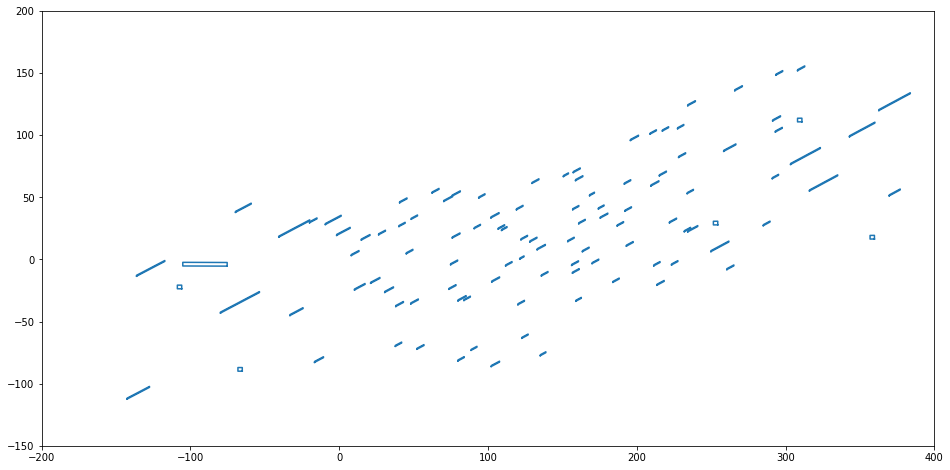

In [58]:

# plot
fig,ax = plt.subplots(1,figsize=(16,8))
ax.set_xlim([-200, 400])
ax.set_ylim([-150, 200])
for slit in SlitData:
    p1=[slit['XMM1'],slit['YMM1']]
    p2=[slit['XMM2'],slit['YMM2']]
    p3=[slit['XMM3'],slit['YMM3']]
    p4=[slit['XMM4'],slit['YMM4']]
    x = [slit['XMM1'],slit['XMM2'],slit['XMM3'],slit['XMM4'],slit['XMM1']]
    y = [slit['YMM1'],slit['YMM2'],slit['YMM3'],slit['YMM4'],slit['YMM1']]
    l = mlines.Line2D(x,y)
    ax.add_line(l)





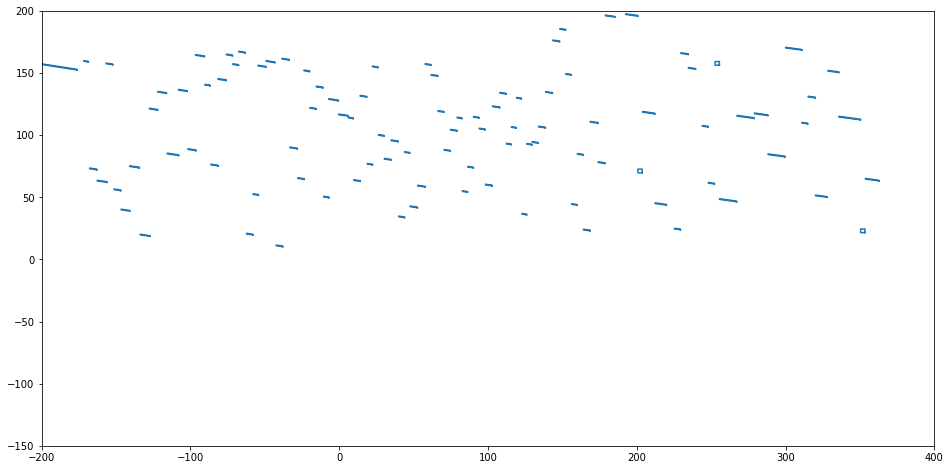

In [64]:
mask_slits = ascii.read('slits')
fig,ax = plt.subplots(1,figsize=(16,8))
ax.set_xlim([-200, 400])
ax.set_ylim([-150, 200])
for slit in mask_slits:
    x = [slit['slitX1'],slit['slitX2'],slit['slitX3'],slit['slitX4'],slit['slitX1']]
    y = [slit['slitY1'],slit['slitY2'],slit['slitY3'],slit['slitY4'],slit['slitY1']]
    l = mlines.Line2D(x,y)
    ax.add_line(l)